In [1]:
if 'google.colab' in str(get_ipython()):
  %pip install pycocotools omrdatasettools xmlschema > /dev/null
  %pip install torchvision --upgrade > /dev/null


In [9]:
from omrdatasettools import Downloader, OmrDataset
import xmlschema

import os
import glob
import re
from PIL import Image
from lxml import etree
from pprint import pprint
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

from datasets import MuscimaObjects

In [10]:
muscimaroot = 'muscima'

dataset = MuscimaObjects.MuscimaObjects(muscimaroot)

### Model

In [11]:
from visionutils.engine import train_one_epoch, evaluate
import visionutils.utils as utils
import visionutils.transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Initialized module


In [12]:
dataset = MuscimaObjects.MuscimaObjects('muscima', transforms=get_transform(train=True))
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn)

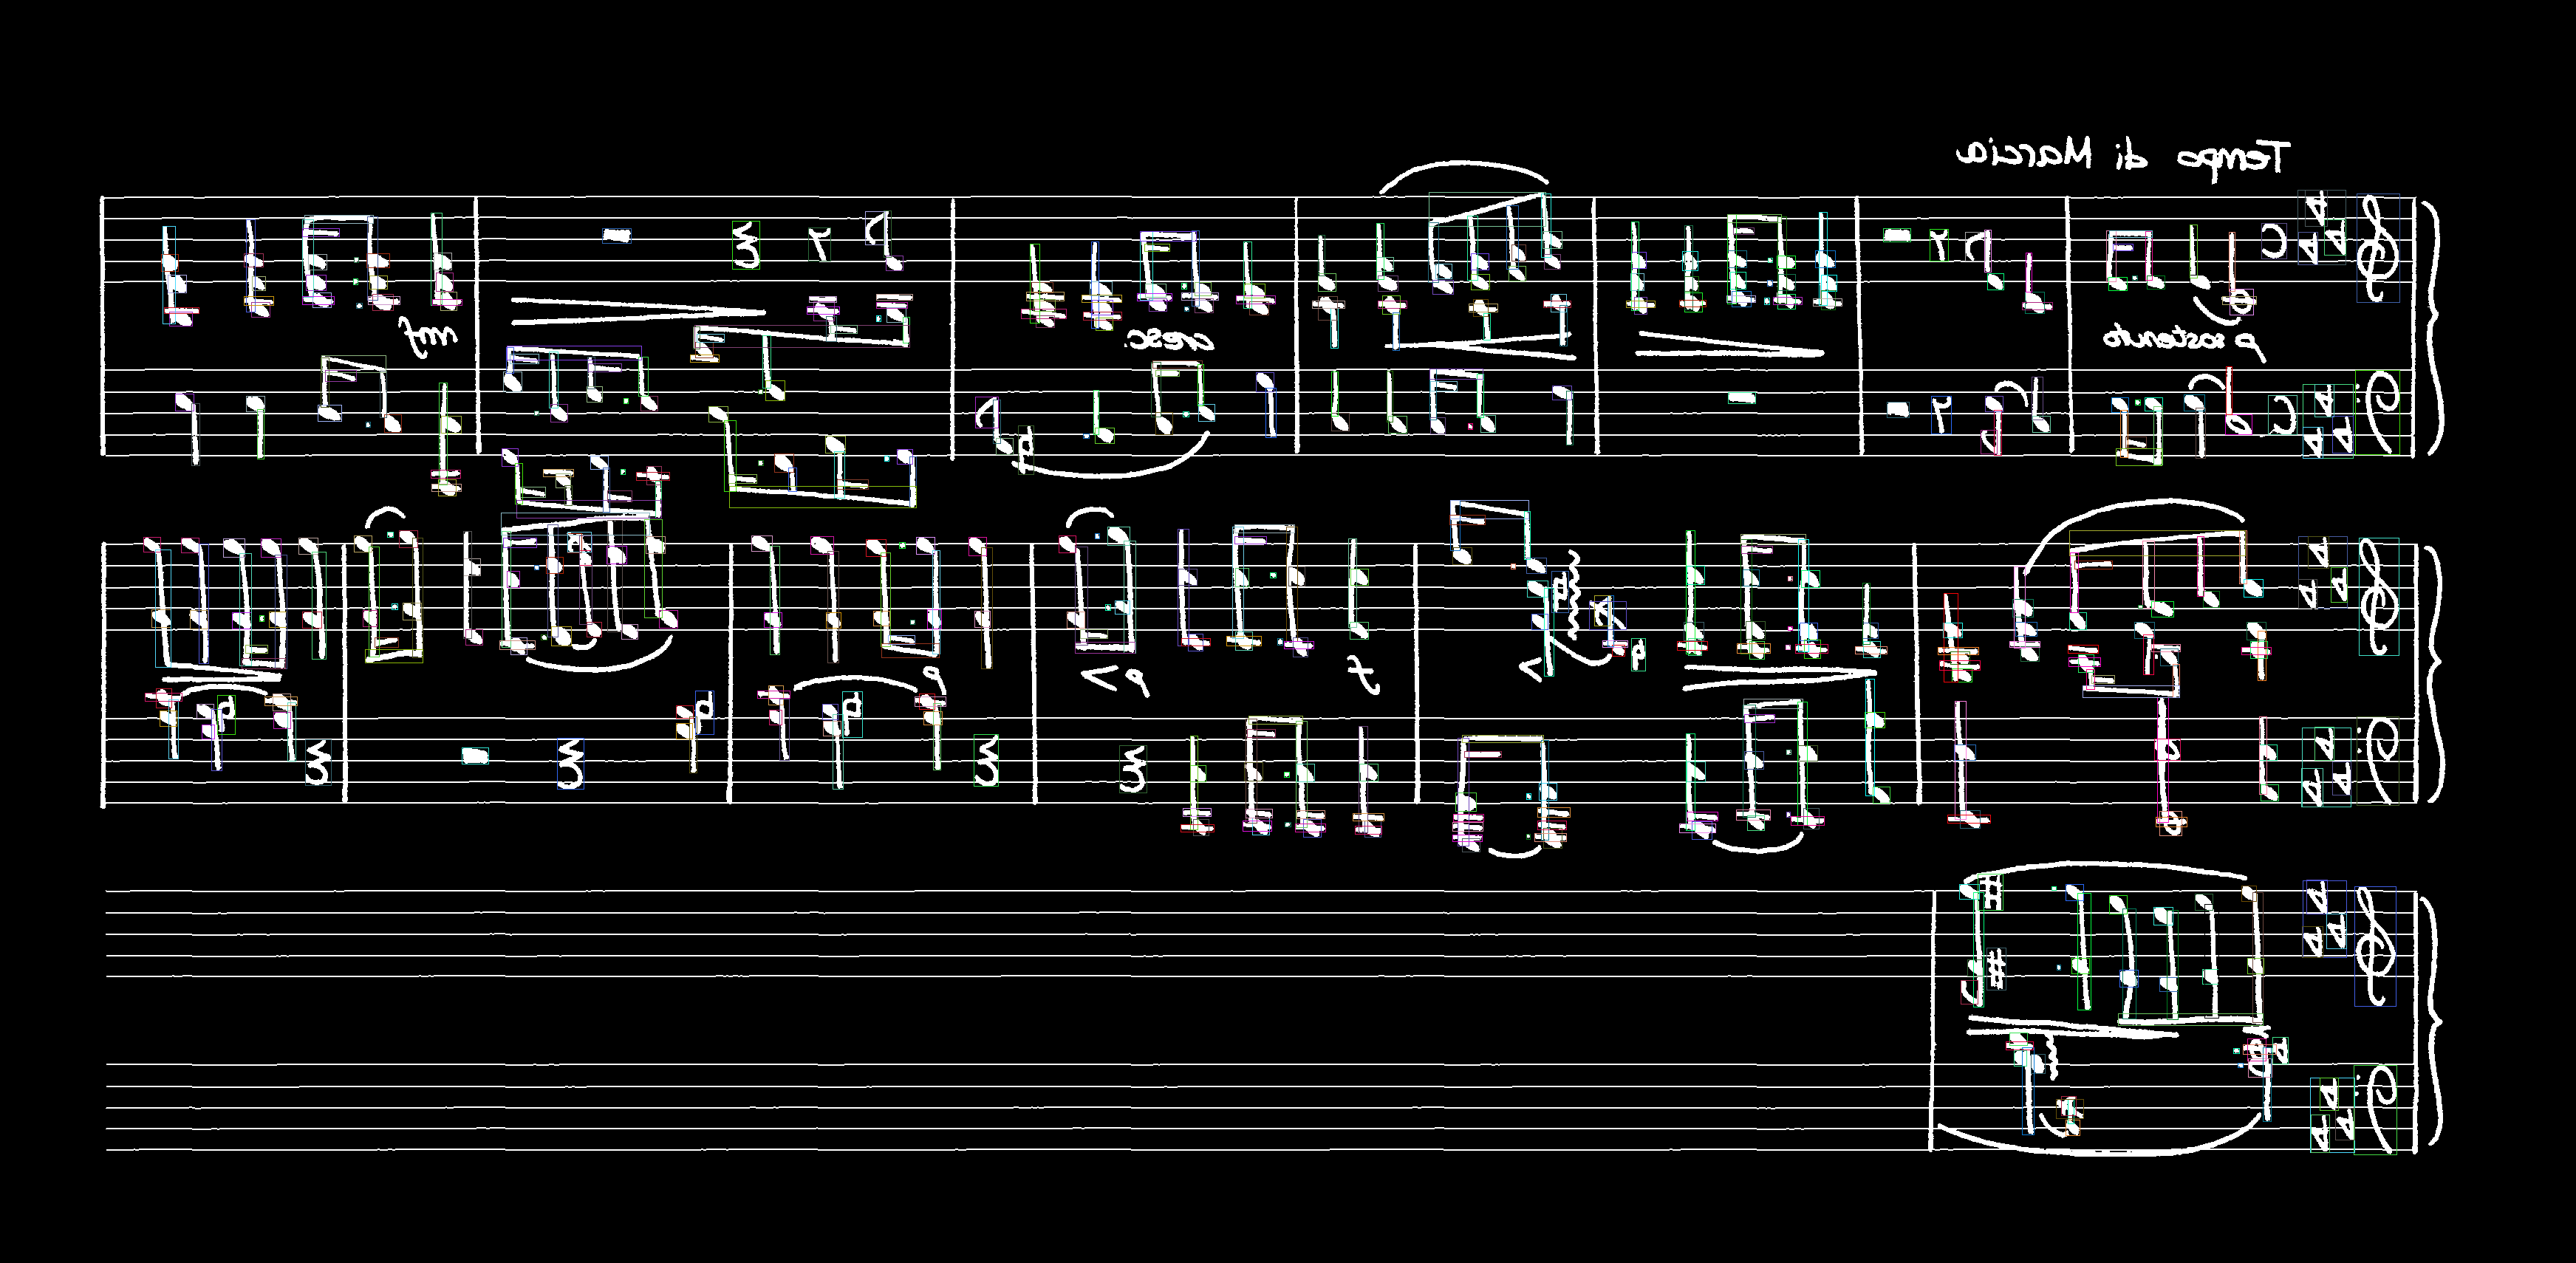

In [13]:
sample_im, sample_ann = dataset[0]
sample_boxes = sample_ann['boxes']

sample_im = (255*sample_im).type(torch.ByteTensor)

from torchvision.utils import draw_bounding_boxes


sample_im_with_bounding_boxes = draw_bounding_boxes(sample_im, sample_boxes)

sample_im_with_bounding_boxes.shape
Image.fromarray(np.moveaxis(sample_im_with_bounding_boxes.numpy(), 0, -1))

###Import Model

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.anchor_utils import AnchorGenerator

# Pretrained model
def get_faster_rcnn_with_n_classes(n: int):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, trainable_backbone_layers=1)

  in_features = model.roi_heads.box_predictor.cls_score.in_features

  model.roi_heads.detections_per_img = 750

  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, n)

  return model

In [14]:
from vision.torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn_v2

ModuleNotFoundError: No module named 'torchvision._utils'

In [2]:
from torch.utils.model_zoo import load_url


fasterrcnn_resnet50_fpn_v2_weights = load_url("https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth", progress=True)

#class FasterRCNN_ResNet50_FPN_V2_Weights(WeightsEnum):
#    COCO_V1 = Weights(
#        url="https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth",
#        transforms=ObjectDetection,
#        meta={
#            **_COMMON_META,
#            "publication_year": 2021,
#            "num_params": 43712278,
#            "recipe": "https://github.com/pytorch/vision/pull/5763",
#            "map": 46.7,
#        },
#    )
#    DEFAULT = COCO_V1

In [8]:


#torch.nn.Module.load_state_dict(state_dict=fasterrcnn_resnet50_fpn_v2_weights)


TypeError: load_state_dict() missing 1 required positional argument: 'self'

In [ ]:
import torch
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.rpn import RPNHead
import torchvision.models.detection.faster_rcnn
from FastRCNNConvFCHead import FastRCNNConvFCHead
import torch.nn as nn
num_classes = 4


backbone = resnet_fpn_backbone('resnet50', pretrained=True)

anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
rpn_anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)

rpn_head = RPNHead(backbone.out_channels, rpn_anchor_generator.num_anchors_per_location()[0])
box_head = FastRCNNConvFCHead((backbone.out_channels, 7, 7 ), [256, 256, 256, 256], [1024], norm_layer=nn.BatchNorm2d)

model = FasterRCNN(
    backbone, 
    num_classes=num_classes,
    rpn_anchor_generator=rpn_anchor_generator,
    rpn_head=rpn_head,
    box_head=box_head)

#model.load_state_dict(state_dict=fasterrcnn_resnet50_fpn_v2_weights)

In [8]:
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x) 

In [16]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

def constructresnet():
  # load a pre-trained model for classification and return
  # only the features
  backbone = resnet_fpn_backbone('resnet50', pretrained=True)
  # FasterRCNN needs to know the number of
  # output channels in a backbone. For mobilenet_v2, it's 1280
  # so we need to add it here
  
  # let's make the RPN generate 5 x 3 anchors per spatial
  # location, with 5 different sizes and 3 different aspect
  # ratios. We have a Tuple[Tuple[int]] because each feature
  # map could potentially have different sizes and
  # aspect ratios
  #anchor_sizes = ((32,), (64,), (128,), (512,))
  anchor_sizes = ((32,),)
  aspect_ratios = ((1.0,),) #* len(anchor_sizes)
  
  anchor_generator = AnchorGenerator()
  # let's define what are the feature maps that we will
  # use to perform the region of interest cropping, as well as
  # the size of the crop after rescaling.
  # if your backbone returns a Tensor, featmap_names is expected to
  # be [0]. More generally, the backbone should return an
  # OrderedDict[Tensor], and in featmap_names you can choose which
  # feature maps to use.
  roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                  output_size=7,
                                                  sampling_ratio=2)
  # put the pieces together inside a FasterRCNN model
  model = FasterRCNN(backbone,
                     num_classes=2,
                     rpn_anchor_generator=anchor_generator,
                     box_roi_pool=roi_pooler)
  

In [17]:
model = get_faster_rcnn_with_n_classes(len(dataset.label_list) + 1)

In [5]:
# Test

images, targets = next(iter(dataloader))

images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
#targets = [{k: v for k, v in t.items()} for t in targets]
#output = model(images, targets)

model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x) 

NameError: name 'dataloader' is not defined

In [19]:
dataset = MuscimaObjects('muscima', transforms=get_transform(train=True))
dataset_test = MuscimaObjects('muscima', transforms=get_transform(train=False))

#splits
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-40])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-40:])

print(len(dataset))
print(len(dataset_test))

#dataloaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

100
40


In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

# optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# learning rate 10x reduction every three epocs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

In [21]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 24

run_training_and_validation = True

if run_training_and_validation:
  for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/100]  eta: 0:04:03  lr: 0.000055  loss: 9.6574 (9.6574)  loss_classifier: 3.6298 (3.6298)  loss_box_reg: 0.4368 (0.4368)  loss_objectness: 4.8569 (4.8569)  loss_rpn_box_reg: 0.7339 (0.7339)  time: 2.4310  data: 0.1880  max mem: 3582
Epoch: [0]  [ 10/100]  eta: 0:01:16  lr: 0.000560  loss: 4.8784 (5.6143)  loss_classifier: 3.1733 (2.9062)  loss_box_reg: 0.4158 (0.4278)  loss_objectness: 0.7918 (1.5929)  loss_rpn_box_reg: 0.6404 (0.6874)  time: 0.8555  data: 0.2495  max mem: 6275
Epoch: [0]  [ 20/100]  eta: 0:01:02  lr: 0.001065  loss: 2.8516 (4.2073)  loss_classifier: 1.5645 (2.2054)  loss_box_reg: 0.3811 (0.3651)  loss_objectness: 0.3826 (0.9743)  loss_rpn_box_reg: 0.6367 (0.6625)  time: 0.6926  data: 0.2853  max mem: 6275
Epoch: [0]  [ 30/100]  eta: 0:00:50  lr: 0.001569  loss: 2.5114 (3.5952)  loss_classifier: 1.2965 (1.8665)  loss_box_reg: 0.3018 (0.3552)  loss_objectness: 0.2571 (0.7341)  loss_rpn_box_reg: 0.6068 (0.6394)  time: 0.6555  data: 0.2906  max mem: 6275


###Visualization

In [22]:
def visualize_bboxes(image, target, labels=None, threshold=0.5):
    colors = ['000000', 'red', 'blue', 'green', 'yellow']
    sample_boxes = target['boxes']
    sample_scores = target['scores']
    sample_labels = target['labels']
    idx = torch.where(sample_scores > threshold)
    boxes_sliced = sample_boxes[idx]
    labels_sliced = sample_labels[idx].tolist()
    labels_list_str = None
    if labels is not None:
        labels_list_str = list(labels[val] for val in labels_sliced)
        colors_list = list(colors[val] for val in labels_sliced)
    sample_image = (image*255).type(torch.ByteTensor)

    sample_im_with_bounding_boxes = draw_bounding_boxes(sample_image, boxes_sliced, colors='red', width=3, font_size=32)

    return Image.fromarray(np.moveaxis(sample_im_with_bounding_boxes.numpy(), 0, -1))


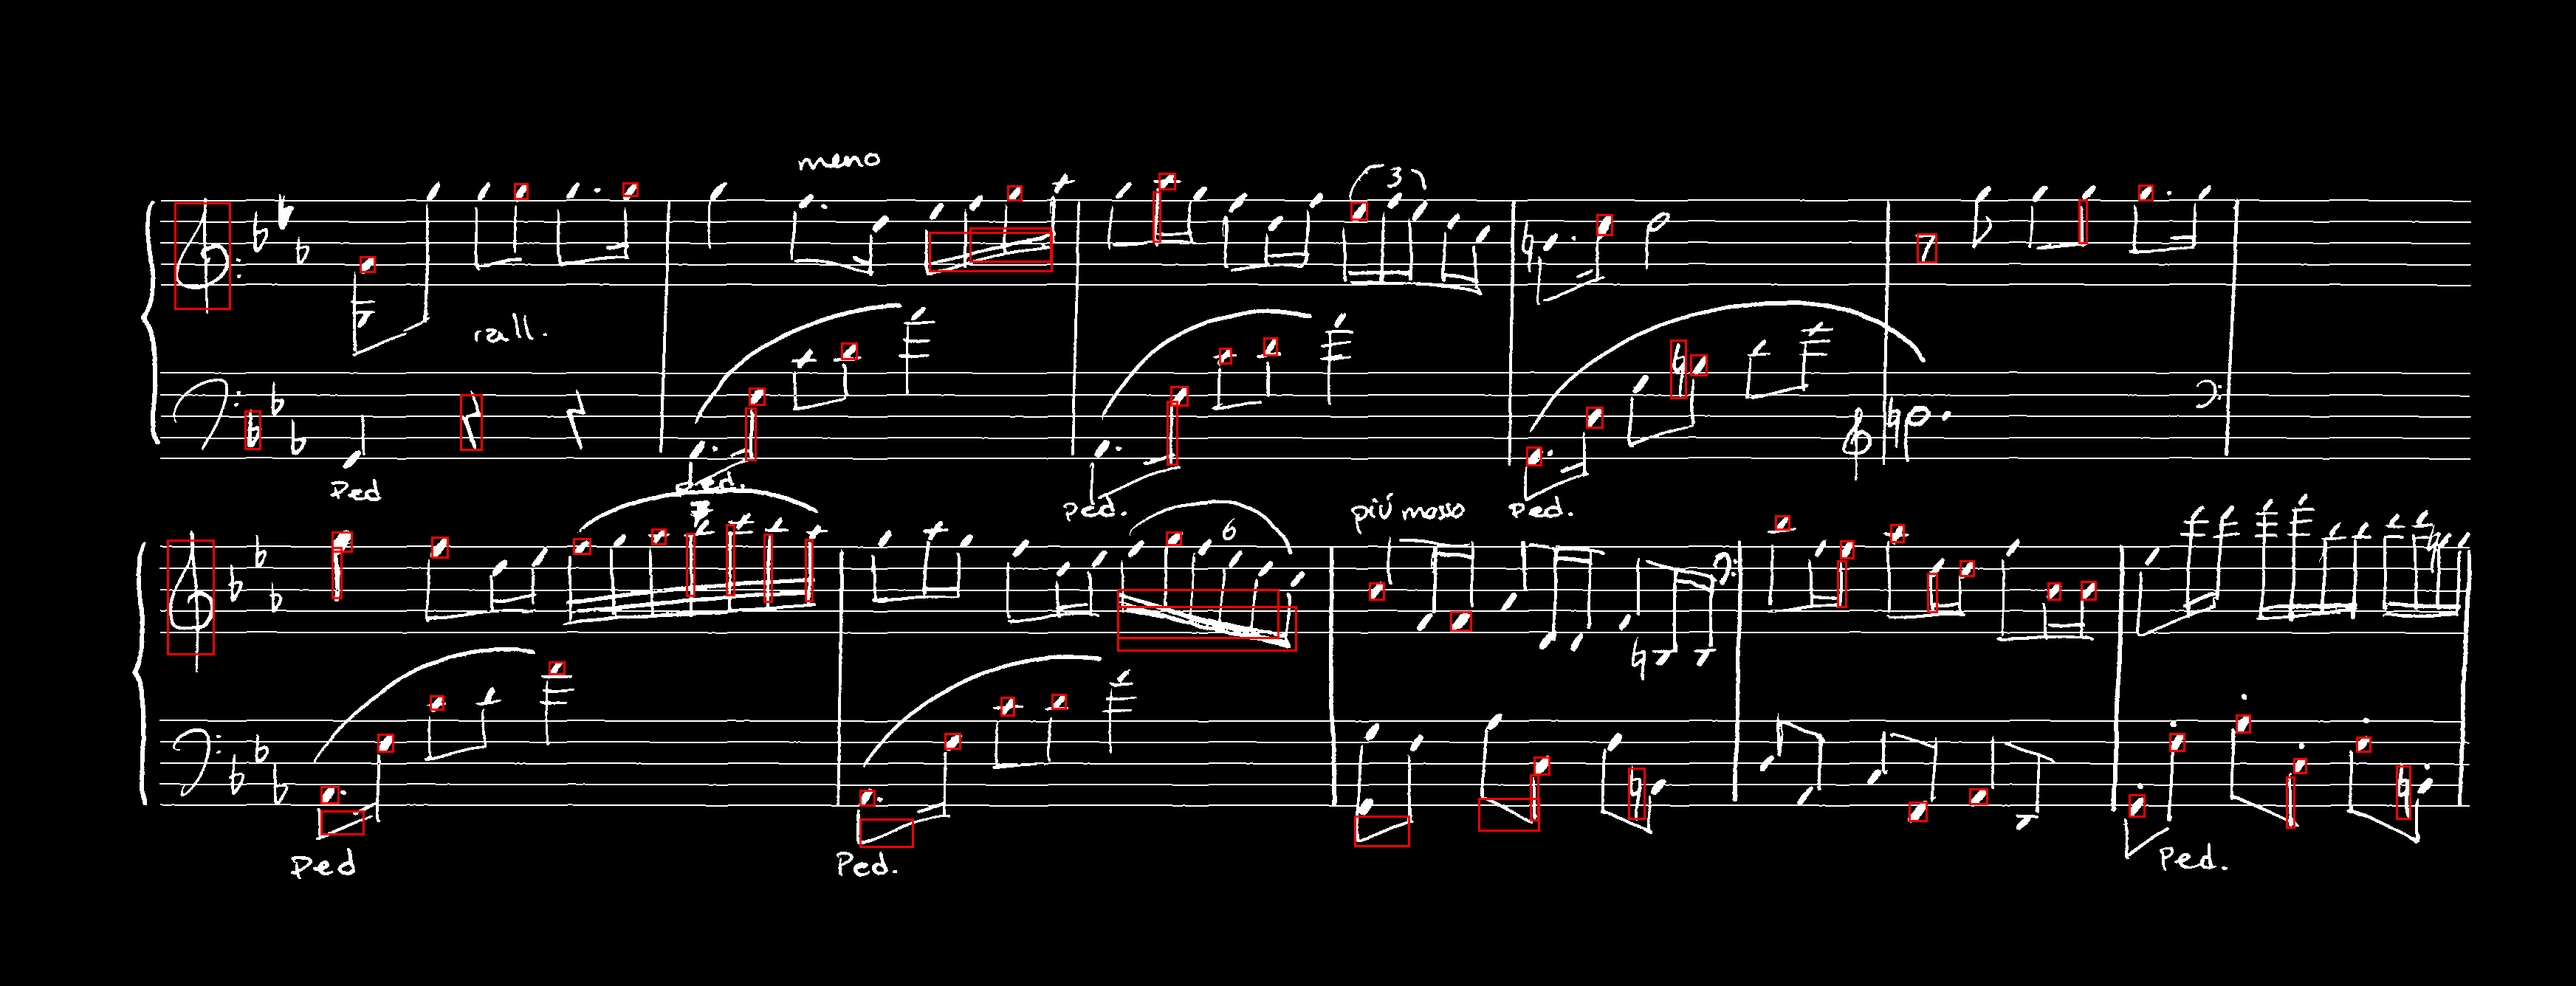

In [27]:
model.eval()
if torch.cuda.is_available():
  torch.cuda.synchronize()
image, target = next(iter(data_loader_test))
image = list(img.to(torch.device('cuda')) for img in image)
detections = model(image)
labels = {1: 'system_measures', 2: 'stave_measures', 3: 'staves'}
visualize_bboxes(image[0], detections[0], threshold=0.5)

In [24]:
detections[0]['boxes'].shape
torch.sum(detections[0]['labels']==1)

tensor(56, device='cuda:0')

In [25]:
# Example save everything
SAVE_ENTIRE_MODEL = "muscima_objects.pt"

torch.save(model, SAVE_ENTIRE_MODEL)